### Unit: Data Science Technology and Systems PG (11523), Semester 2 2021
### Assignment: Final Project

### Student: Saud Alshammari
### UNI-No: U3197222

___________________________________________________________________________________________

# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 

### 1. Determine if and why ML is an appropriate solution to deploy.
Applying machine learning techniques to solve this problem is very appropriate, as we will deal with a very large data set, we would be able to reach what we aim to with high computational speed and accuracy. Nevertheless, machine learning models can be used as base models if we end up with unsatisfactory results and we want to apply other techniques such as deep learning.

### 2. Formulate the business problem, success metrics, and desired ML output.
The problem in hand is to investigate whether the weather had any an effect on the flight's delays and predict that. This project aims to build and deploy a classification model that classify whether a given flight would experience a delay or not. The model should result in a reliable classification accuracy which will be confirmed using the confusion matrix.

### 3. Identify the type of ML problem you’re dealing with.
In this project we will deal with a binary classification problem

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [1]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>
import glob
from datetime import datetime

# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [3]:
# download the files

# <note: make them all relative, absolute path is not accepted>
zip_path = 'C:/Users/Sbals/Documents/Semester4/DataScienceTechnologyandSystemsPG11523/DSTS_FinalProject/raw_data'
base_path = 'C:/Users/Sbals/Documents/Semester4/DataScienceTechnologyandSystemsPG11523/DSTS_FinalProject'
csv_base_path = 'C:/Users/Sbals/Documents/Semester4/DataScienceTechnologyandSystemsPG11523/DSTS_FinalProject/All_data_files'

!mkdir -p {'All_data_files'}

In [4]:
# How many zip files do we have? write a code to answer it.
print('Total number of Zip files = ', len(ZipFile(zip_path+'/OneDrive_2_31-10-2021.zip').namelist()))

Total number of Zip files =  60


#### Extract CSV files from ZIP files

In [5]:
def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path)   
    except:
        print(f'zip2csv failed for {zipFile_name}')
    
    for z2csv in glob.glob(file_path + "/*.zip"): # to get csv files
        csv_f = ZipFile(z2csv) 
        csv_f.extractall(path=file_path)


# Run the function
zip2csv(zip_path+'/OneDrive_2_31-10-2021.zip', csv_base_path)

# to delete the zipped files after unzipping it
for remove_z in glob.glob(csv_base_path + "/*.zip"):
    os.remove(remove_z)

Extracting C:/Users/Sbals/Documents/Semester4/DataScienceTechnologyandSystemsPG11523/DSTS_FinalProject/raw_data/OneDrive_2_31-10-2021.zip 


In [6]:
# How many csv files have we extracted? write a code to answer it.
print('Total number of CSV files = ', len([F for F in os.listdir(csv_base_path) if '.csv' in F]))

Total number of CSV files =  60


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [7]:
from IPython.display import IFrame
IFrame(src=os.path.relpath(f"{csv_base_path}/readme.html"), width=1000, height=600)

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [48]:
df_temp = pd.read_csv(csv_base_path+'/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv')

**Question**: Print the row and column length in the dataset, and print the column names.

In [49]:
df_shape = df_temp.shape
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

In [50]:
df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,3,9,16,7,2018-09-16,9E,20363,9E,N316PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,3,9,17,1,2018-09-17,9E,20363,9E,N916XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,3,9,20,4,2018-09-20,9E,20363,9E,N371CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,9,21,5,2018-09-21,9E,20363,9E,N601LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018,3,9,23,7,2018-09-23,9E,20363,9E,N906XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [11]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [12]:
delay_columns = [col for col in df_temp.columns if 'Del' in col]
print(f'The columns that refer to delay data are :')
print('#########')
delay_columns

The columns that refer to delay data are :
#########


['DepDelay',
 'DepDelayMinutes',
 'DepDel15',
 'DepartureDelayGroups',
 'ArrDelay',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrivalDelayGroups',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'DivArrDelay']

Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [13]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", len(df_temp.axes[0]) , " and ", len(df_temp.axes[1]))
print("The years in this dataset are: ", np.unique(df_temp.Year)[0])
print("The months covered in this dataset are: ", np.unique(df_temp.Month)[0])
print('____________________________________________')
print()
print("The date range for data is :" , min(df_temp.FlightDate), " to ", max(df_temp.FlightDate))
print('________________________________________________________')
print()
print("The airlines covered in this dataset are: ", list(np.unique(df_temp.Reporting_Airline)))
print('___________________________________________________________________________________________________________________')
print()
print("The Origin airports covered are: ", list(np.unique(df_temp.Origin)))
print('___________________________________________________________________________________________________________________')
print()
print("The Destination airports covered are: ", list(np.unique(df_temp.Dest)))

The #rows and #columns are  585749  and  110
The years in this dataset are:  2018
The months covered in this dataset are:  9
____________________________________________

The date range for data is : 2018-09-01  to  2018-09-30
________________________________________________________

The airlines covered in this dataset are:  ['9E', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'G4', 'HA', 'MQ', 'NK', 'OH', 'OO', 'UA', 'WN', 'YV', 'YX']
___________________________________________________________________________________________________________________

The Origin airports covered are:  ['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADK', 'ADQ', 'AEX', 'AGS', 'ALB', 'ALO', 'AMA', 'ANC', 'APN', 'ASE', 'ATL', 'ATW', 'AUS', 'AVL', 'AVP', 'AZA', 'AZO', 'BDL', 'BET', 'BFF', 'BFL', 'BGM', 'BGR', 'BHM', 'BIL', 'BIS', 'BJI', 'BKG', 'BLI', 'BLV', 'BMI', 'BNA', 'BOI', 'BOS', 'BPT', 'BQK', 'BQN', 'BRD', 'BRO', 'BRW', 'BTM', 'BTR', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN', 'CAE', 'CAK', 'CDC', 'CDV

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [14]:
counts = pd.DataFrame({'Origin':df_temp.Origin.value_counts(), 'Destination':df_temp.Dest.value_counts()})
counts

,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
ACK,129,129
ACT,135,135
ACV,122,122
ACY,242,242
ADK,9,9


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [15]:
Origin_Top15 = counts.sort_values(by=['Origin'],ascending=False).head(15)# Enter your code here
print(Origin_Top15)
Destination_Top15 = counts.sort_values(by=['Destination'],ascending=False).head(15)# Enter your code here
print(Destination_Top15)

# counts.sort_values(by=['Origin', 'Destination'],ascending=False).head(15)# Enter your code here


     Origin  Destination
ATL   31525        31521
ORD   28257        28250
DFW   22802        22795
DEN   19807        19807
CLT   19655        19654
LAX   17875        17873
SFO   14332        14348
IAH   14210        14203
LGA   13850        13850
MSP   13349        13347
LAS   13318        13322
PHX   13126        13128
DTW   12725        12724
BOS   12223        12227
SEA   11872        11877
     Origin  Destination
ATL   31525        31521
ORD   28257        28250
DFW   22802        22795
DEN   19807        19807
CLT   19655        19654
LAX   17875        17873
SFO   14332        14348
IAH   14210        14203
LGA   13850        13850
MSP   13349        13347
LAS   13318        13322
PHX   13126        13128
DTW   12725        12724
BOS   12223        12227
SEA   11872        11877


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

We have a set of valuable variables that will undoubtedly contribute to the classification of whether the flight will be delayed or not. However, since we are trying to explore the relation of weather with a given flight delay or not, the data we have so far will not be of much help in solving this problem.

________________________________________________________________________________________________________________________________________________________________________

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [24]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """
    # Create an empty dataframe
    dfs_list = []

    # Get all csv files names
    files_names = [i for i in glob.glob(os.path.join(csv_files + "/*.csv"))]

    # read all csv files
    for i in files_names:
        dl = pd.read_csv(i)
        fc = dl[filter_cols]
        fr = fc[(fc[subset_cols[0]].isin(subset_vals[0])) & 
            (fc[subset_cols[1]].isin(subset_vals[1])) & 
            (fc[subset_cols[2]].isin(subset_vals[2]))]
        dfs_list.append(fr)
        
    # Combine all files in the list
    combined_files = pd.concat(dfs_list, axis=0, ignore_index=True)
    
    #export to csv
    combined_files.to_csv(file_name, index=False)
    #<complete the code of this function>

In [17]:
#cols is the list of columns to predict Arrival Delay 
filter_cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [32]:
start = time.time()

combined_csv_filename = f"{csv_base_path}/combined_files.csv"

combine_csv(csv_base_path, filter_cols, subset_cols, subset_vals, combined_csv_filename)
    
print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')


csv's merged in 3.83 minutes


#### Load dataset

Load the combined dataset.

In [53]:
data = pd.read_csv(csv_base_path+'/combined_files.csv')# Enter your code here to read the combined csv file.

Print the first 5 records.

In [35]:
data.head(5)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,TX,2145,0.0,0.0,689.0,3,-20.0,0.0,0.0,99.0
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,GA,945,0.0,0.0,731.0,3,-3.0,0.0,0.0,98.0
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,CO,1855,0.0,0.0,1199.0,5,-7.0,0.0,0.0,174.0
3,2014,1,1,26,7,2014-01-26,DL,ATL,GA,PHX,AZ,1634,0.0,0.0,1587.0,7,-4.0,0.0,0.0,233.0
4,2014,1,1,26,7,2014-01-26,DL,PHX,AZ,ATL,GA,700,0.0,0.0,1587.0,7,-13.0,0.0,0.0,179.0


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [36]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", len(data) , " and ", len(data.columns))
print("The years in this dataset are: ", list(np.unique(data.Year)))
print("The months covered in this dataset are: ", sorted(list(np.unique(data.Month))))
print('____________________________________________')
print()
print("The date range for data is :" , min(data.FlightDate), " to ", max(data.FlightDate))
print('________________________________________________________')
print()
print("The airlines covered in this dataset are: ", list(np.unique(data.Reporting_Airline)))
print('__________________________________________________________________________')
print()
print("The Origin airports covered are: ", list(np.unique(data.Origin)))
print('___________________________________________________________________________________________________')
print()
print("The Destination airports covered are: ", list(np.unique(data.Dest)))

The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2014, 2015, 2016, 2017, 2018]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
____________________________________________

The date range for data is : 2014-01-01  to  2018-12-31
________________________________________________________

The airlines covered in this dataset are:  ['AA', 'DL', 'OO', 'UA', 'WN']
__________________________________________________________________________

The Origin airports covered are:  ['ATL', 'CLT', 'DEN', 'DFW', 'IAH', 'LAX', 'ORD', 'PHX', 'SFO']
___________________________________________________________________________________________________

The Destination airports covered are:  ['ATL', 'CLT', 'DEN', 'DFW', 'IAH', 'LAX', 'ORD', 'PHX', 'SFO']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [54]:
data.rename(columns={'ArrDel15': 'is_delay'}, inplace=True) # Enter your code here
# convert Float to Int
# data['is_delay'] = data['is_delay'].astype(int)

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [55]:
data.isnull().sum() # Enter your code here
# isNull_col = data.columns[data.isna().any()].tolist()

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64

The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [56]:
### Remove null columns
# using dropna() function  
data = data.dropna(axis=0)

# Check again
data.isnull().sum()

Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
Cancelled            0
Diverted             0
Distance             0
DistanceGroup        0
ArrDelay             0
ArrDelayMinutes      0
is_delay             0
AirTime              0
dtype: int64

Get the hour of the day in 24-hour time format from CRSDepTime.

In [57]:
data['DepHourofDay'] = pd.to_datetime(data.CRSDepTime, unit='h').dt.strftime('%H') # Enter your code here

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

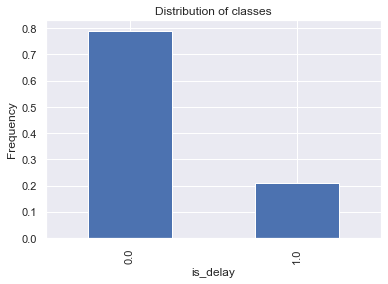

In [41]:
(data.groupby('is_delay').size()/len(data) ).plot(kind='bar')# Enter your code here
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

The dataset is severely unbalanced. This difference rate will render the classification process unreliable.

**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

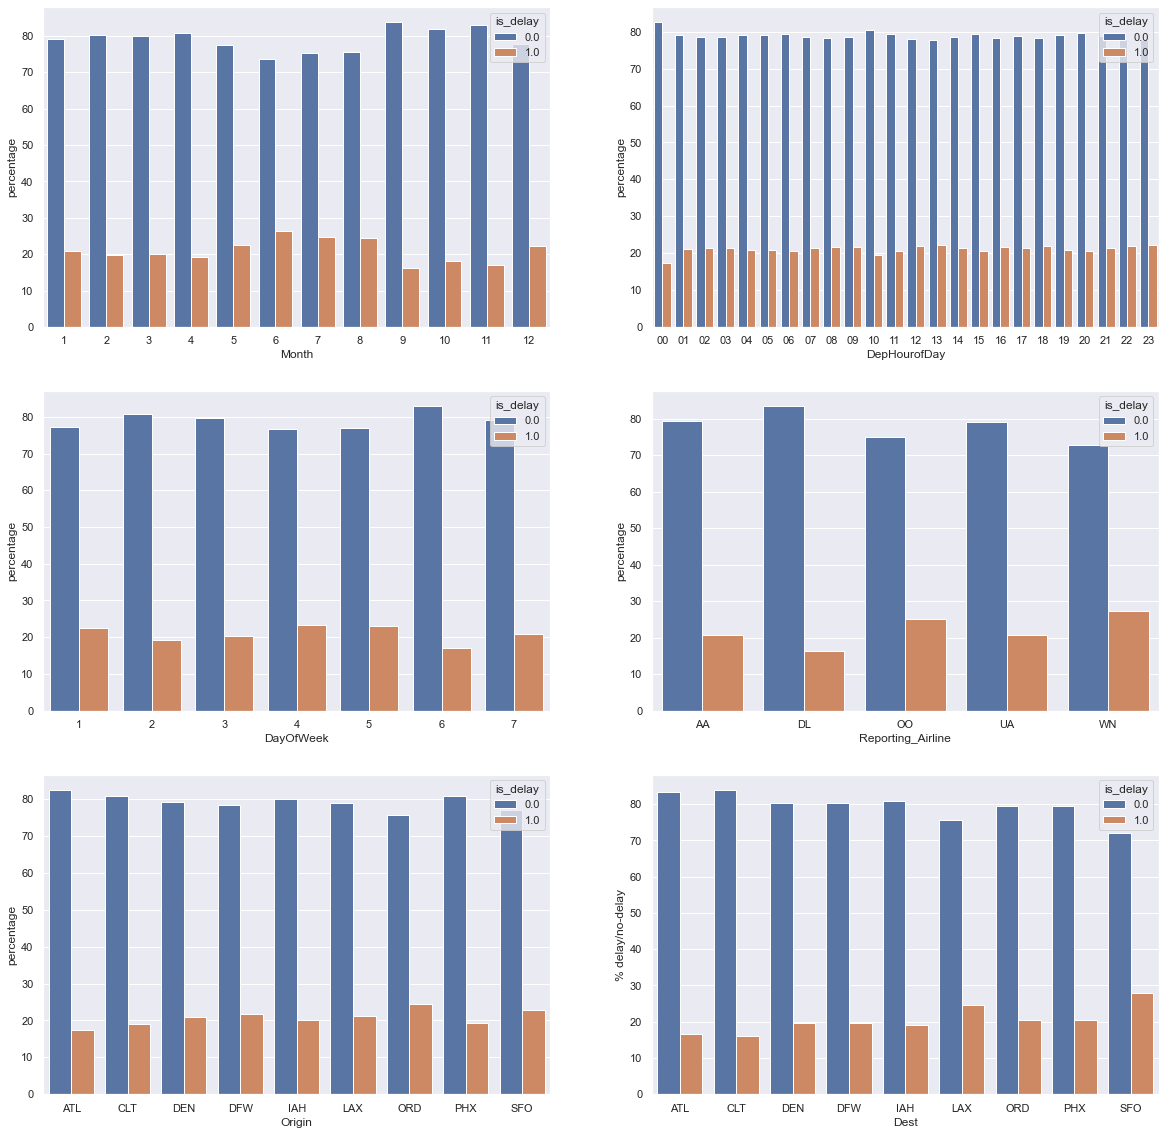

In [42]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

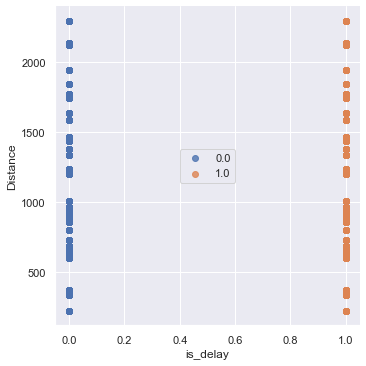

In [43]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

Q1- June

Q2- (13:00). Although the delay distribution is roughly equal along the whole day.

Q3- (4), but 5 also have a high number of delayed flights

Q4- WN

Q5- Origin: ORD / Destination: SFO

Q6- The plot is not showing enough insights to answer this question properly, more investigation is needed.

### Features

Look at all the columns and what their specific types are.

In [44]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [58]:
data_orig = data.copy()
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]

categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']

# Manually bucketizing DepHourofDay to 4 categories representing the day times
data['DepHourofDay'] = data['DepHourofDay'].astype(int)
data['DepHourofDay'] = pd.qcut(data['DepHourofDay'], q=[0, .25, .50, .75, 1], labels= ['Midnight', 'Morning', 'Afternoon', 'Evening'])


for c in categorical_columns:
    data[c] = data[c].astype('category')# Enter your code here


To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [59]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True) # Enter your code here
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns, axis=1, inplace=True)


Check the length of the dataset and the new columnms.

In [60]:
print('The length of the dataset = ', len(data)) # Enter your code here

The length of the dataset =  1635590


In [61]:
print('The new columnms in the dataset = ', data.columns) # Enter your code here

The new columnms in the dataset =  Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airli

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [62]:
data.rename(columns={'is_delay': 'target'}, inplace=True )# Enter your code here
data['target'] = data['target'].astype(int)

In [66]:
# write code to Save the combined csv file (combined_csv_v1.csv) to your local computer
# note this combined file will be used in part B

### Remove null columns
# using dropna() function  
data = data.dropna(axis=0)

#export to csv
data.to_csv(csv_base_path+'/combined_csv_v1.csv', index=False)

# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [ ]:
# classifier 1 with cross_val

# data = pd.read_csv(csv_base_path+'/combined_csv_v1.csv')


# write Code here to split data into train and test
train = data.sample(frac=0.80, random_state=59)
test = data.loc[~data.index.isin(train.index), :]

X = train.drop('target', axis = 1)
y = train['target'].values


# Check the splited data shape
print('X shape =', X.shape)
print('y shape =', y .shape)

CV_classifier1 = LogisticRegression(random_state=43)
CV_classifier1_pred = cross_val_predict(CV_classifier1, X, y, cv=10)

X shape = (1308472, 74)
y shape = (1308472,)


In [ ]:
# classifier 1 without cross_val

# write Code here to split data into train, validate and test
train = data.drop('target', axis = 1)
test = data['target'].values

# Splitting into train and test data set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.30, random_state = 0)

# Check the splited data shape
print('X_train shape =', X_train.shape)
print('y_train shape =', y_train.shape)
print('_______________________________')
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)


from sklearn.linear_model import LogisticRegression
classifier1 = LogisticRegression(random_state=0).fit(X_train, y_train)
y_predicted1 = classifier1.predict(X_test)

X_train shape = (1144913, 74)
y_train shape = (1144913,)
_______________________________
X_test shape =  (490677, 74)
y_test shape =  (490677,)


### Baseline classification model

## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [ ]:
def plot_confusion_matrix(classifier, X_test, test_labels, target_predicted):
    from sklearn.metrics import plot_confusion_matrix, accuracy_score
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_confusion_matrix(classifier, X_test, y_test, ax=ax)
    plt.title('classifier1 Logistic Regression Confusion Matrix \nAccuracy:{0:.3f}'.format(accuracy_score(test_labels, target_predicted)))
    plt.ylabel('True Positive')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()


def plot_roc(test_labels, target_predicted):
    from sklearn.metrics import roc_curve, roc_auc_score, auc
    False_Positive_LR, True_Positive_LR, threshold = roc_curve(test_labels, target_predicted)
    Roc_auc_LR = auc(False_Positive_LR, True_Positive_LR)

    plt.figure(figsize=(6,6))
    plt.plot(False_Positive_LR, True_Positive_LR, color= 'g', label = 'AUC = %0.2f' % Roc_auc_LR)
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend(loc = 'lower right')
    plt.title('classifier1 Logistic Regression ROC')
    plt.title('classifier1 Logistic Regression ROC \n:{0:.3f}'.format(roc_auc_score(test_labels, target_predicted)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

[[1033315       1]
 [ 275153       3]]


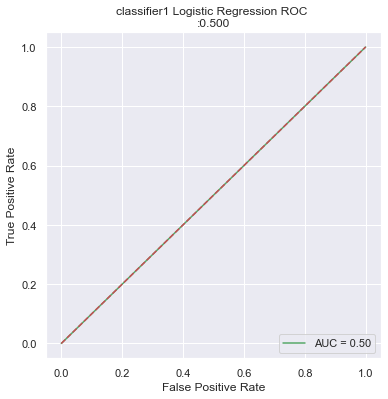

              precision    recall  f1-score   support

           0       0.79      1.00      0.88   1033316
           1       0.75      0.00      0.00    275156

    accuracy                           0.79   1308472
   macro avg       0.77      0.50      0.44   1308472
weighted avg       0.78      0.79      0.70   1308472



In [ ]:
# classifier 1 with cross_val
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
print(confusion_matrix(y, CV_classifier1_pred))

False_Positive_LR, True_Positive_LR, threshold = roc_curve(y, CV_classifier1_pred)
Roc_auc_LR = auc(False_Positive_LR, True_Positive_LR)
plt.figure(figsize=(6,6))
plt.plot(False_Positive_LR, True_Positive_LR, color= 'g', label = 'AUC = %0.2f' % Roc_auc_LR)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc = 'lower right')
plt.title('classifier1 ROC \n:{0:.2f}'.format(roc_auc_score(y, CV_classifier1_pred)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y, CV_classifier1_pred)) 

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

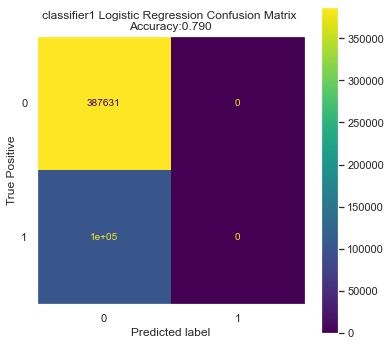

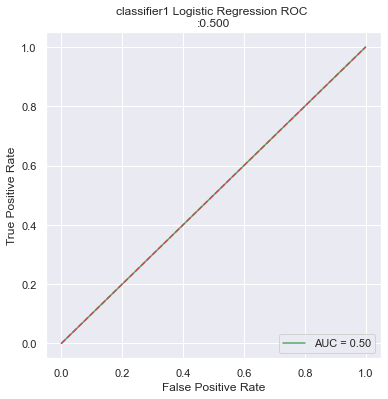

In [ ]:
plot_confusion_matrix(classifier1, X_test, y_test, y_predicted1) # Enter you code here
plot_roc(y_test, y_predicted1)

To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted1)) # Enter you code here

              precision    recall  f1-score   support

           0       0.79      1.00      0.88    387631
           1       0.00      0.00      0.00    103046

    accuracy                           0.79    490677
   macro avg       0.39      0.50      0.44    490677
weighted avg       0.62      0.79      0.70    490677



### Key questions to consider:

1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)?

#### Q1- The models performance on the test set was way faster, yet had a better accuracy on the train set. However, both model have resulted in a very poor classification accuracy.

#### Q2- There are a slight deference between both models precision and support. It is clear that this difference in results came due to that the first model was trained and tested using Cross Validation method.

#### Q3- According to the confusion matrix, the results are not satisfactory. In the next step, we will extract and add new features.


**Question**: What can you summarize from the confusion matrix?


#### The problem of unbalanced classes that this data set have is negatively effecting the models performance, which the confusion matrix is reflecting.

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitLab repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitLab account.


In [ ]:
### Provide a link for your Gitlab repository here

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [67]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = set(holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18)

### Add indicator variable for holidays
data_orig['is_holiday'] = data_orig['FlightDate'].isin(holidays)

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [ ]:
# download data from the link above and place it into the data folder

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [79]:
weather = pd.read_csv(zip_path+'/daily-summaries-2021-11-07T07-46-11.csv') # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = dict(zip(station, airports)) 
weather['airport'] = weather['STATION'].map(station_map)

Create another column called `MONTH` from the `DATE` column.

In [80]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX,01


### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [81]:
weather.SNOW.fillna(0, inplace=True)# Enter your code here
weather.SNWD.fillna(0, inplace=True)# Enter your code here
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [82]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = weather[weather['TAVG'].isna()].index# Enter your code here 
TMAX_idx = weather[weather['TMAX'].isna()].index # Enter your code here 
TMIN_idx = weather[weather['TMIN'].isna()].index# Enter your code here 
TAVG_idx

Int64Index([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
             3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
             3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
             3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
             4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
             4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
             4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420],
           dtype='int64')

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [83]:
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,0.0,0.0,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,0.0,0.0,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,0.0,0.0,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,0.0,0.0,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,0.0,0.0,151.0,244.0,83.0,LAX,01


In [84]:
weather_impute = weather.groupby(['MONTH','STATION']).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

,MONTH,STATION,TAVG,TMAX,TMIN
0,01,USW00003017,-2.741935,74.000000,-69.858065
1,01,USW00003927,79.529032,143.767742,20.696774


Merge the mean data with the weather data.

In [85]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [86]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [87]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [88]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [89]:
sum(data.isna().any())

0

In [90]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [91]:
data.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
0,0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [93]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True) # Enter your code here
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns, axis=1, inplace=True)

# # I disabled the 'drop_first' feature when creating dummies so we don't lose the first day, month and year 2014. 
# # #Then we will delete the False is_holiday, as it is a repetition of the True is_holiday thus we do not need it.
# data.drop(categorical_columns, axis=1, inplace=True)

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [94]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [95]:
data.rename(columns={'is_delay': 'target'}, inplace=True) # Enter your code here
data['target'] = data['target'].astype(int)

In [96]:
data.head(2)

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_True
0,0,689.0,09,33,0,54.0,30,0,130.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0,731.0,09,39,0,136.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B

### Remove null columns
# using dropna() function  
data = data.dropna(axis=0)

#export to csv
data.to_csv(csv_base_path+'/combined_csv_v2.csv', index=False)

### New baseline classifier

Now, see if these new features add any predictive power to the model.

Create the training and testing sets again.

In [ ]:
# data = pd.read_csv(csv_base_path+'/combined_csv_v2.csv')
# classifier 2 with cross_val

# write Code here to split data into train and test
train = data.sample(frac=0.80, random_state=59)
test = data.loc[~data.index.isin(train.index), :]

X = train.drop('target', axis = 1)
y = train['target'].values


# Check the splited data shape
print('X shape =', X.shape)
print('y shape =', y .shape)

CV_classifier2 = LogisticRegression(random_state=43)
CV_classifier2_pred = cross_val_predict(CV_classifier2, X, y, cv=10)

X shape = (1308472, 85)
y shape = (1308472,)


In [ ]:
# classifier 2 without cross_val

# write Code here to split data into train, validate and test
train = data.drop('target', axis = 1)
test = data['target'].values

# Splitting into train and test data set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.30, random_state = 0)

# Check the splited data shape
print('X_train shape =', X_train.shape)
print('y_train shape =', y_train.shape)
print('_______________________________')
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)


from sklearn.linear_model import LogisticRegression
classifier2 = LogisticRegression(random_state=0).fit(X_train, y_train)
y_predicted2 = classifier2.predict(X_test)

X_train shape = (1144913, 85)
y_train shape = (1144913,)
_______________________________
X_test shape =  (490677, 85)
y_test shape =  (490677,)


In [ ]:
def plot_confusion_matrix(classifier, X_test, test_labels, target_predicted):
    from sklearn.metrics import plot_confusion_matrix, accuracy_score
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_confusion_matrix(classifier, X_test, y_test, ax=ax)
    plt.title('classifier1 Logistic Regression Confusion Matrix \nAccuracy:{0:.3f}'.format(accuracy_score(test_labels, target_predicted)))
    plt.ylabel('True Positive')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

def plot_roc(test_labels, target_predicted):
    from sklearn.metrics import roc_curve, auc
    False_Positive_LR, True_Positive_LR, threshold = roc_curve(test_labels, target_predicted)
    Roc_auc_LR = auc(False_Positive_LR, True_Positive_LR)
    plt.figure(figsize=(6,6))
    plt.plot(False_Positive_LR, True_Positive_LR, color= 'g', label = 'AUC = %0.2f' % Roc_auc_LR)
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend(loc = 'lower right')
    plt.title('classifier1 Logistic Regression ROC')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

[[1024562    8754]
 [ 266934    8222]]


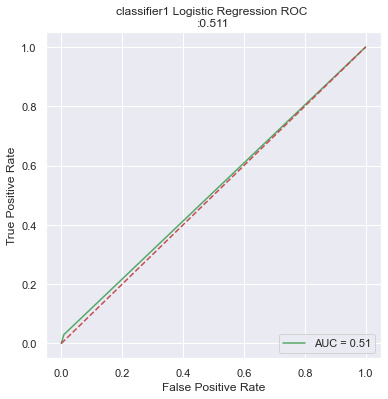

              precision    recall  f1-score   support

           0       0.79      0.99      0.88   1033316
           1       0.48      0.03      0.06    275156

    accuracy                           0.79   1308472
   macro avg       0.64      0.51      0.47   1308472
weighted avg       0.73      0.79      0.71   1308472



In [ ]:
# classifier 1 with cross_val
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
print(confusion_matrix(y, CV_classifier2_pred))

False_Positive_LR, True_Positive_LR, threshold = roc_curve(y, CV_classifier2_pred)
Roc_auc_LR = auc(False_Positive_LR, True_Positive_LR)
plt.figure(figsize=(6,6))
plt.plot(False_Positive_LR, True_Positive_LR, color= 'g', label = 'AUC = %0.2f' % Roc_auc_LR)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc = 'lower right')
plt.title('classifier1 Logistic Regression ROC \n:{0:.3f}'.format(roc_auc_score(y, CV_classifier2_pred)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y, CV_classifier2_pred)) 

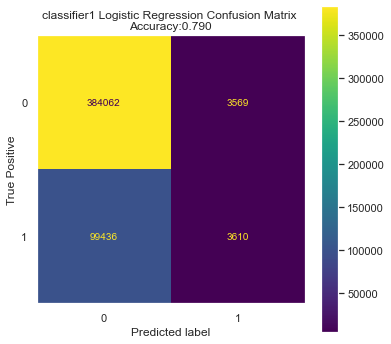

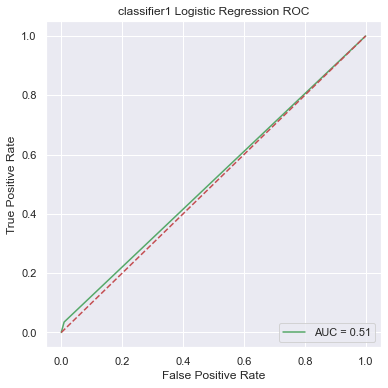

              precision    recall  f1-score   support

           0       0.79      0.99      0.88    387631
           1       0.50      0.04      0.07    103046

    accuracy                           0.79    490677
   macro avg       0.65      0.51      0.47    490677
weighted avg       0.73      0.79      0.71    490677



In [ ]:
plot_confusion_matrix(classifier2, X_test, y_test, y_predicted2) # Enter you code here
plot_roc(y_test, y_predicted2)
print(classification_report(y_test, y_predicted2)) # Enter you code here

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

Question: did you notice a difference by adding the extra data on the results?

### Definitely, the results improved on all the metrics used for the evaluation. However, the difference between both models are not that significant.

# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

In [ ]:
# copy the link here

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

Q1- The classification results from all the models tested did not reach what can be presented as a useful commercial solution. Deep learning techniques can be applied as they can bypass many of the machine learning disadvantages, thus we may get better results with higher computational speed.

Q2- It wasn't a huge improvement, but it's an improvement that can be built on. I think that the features engineering phase and the use of another data set to extract, add and link new properties had the greatest impact on improving the classification accuracy.

Q3- Using "AWS sagemaker" and "Tableau" the most challenging task I had encountered throughout this project.

Q4:
1- Features engineering
2- Practicing Tableau
3- Using AWS services to build, train, and deploy machine learning models.